![Imagem 1](insurance-health.png)

## Sobre

Simulando preços de seguro saúde.

### Dicionário de Dados

- **age:** idade do beneficiário;

- **sex:** gênero do contratante;

- **bmi:** índice de massa corporal;

- **children:** número de crianças cobertos pelo plano de saúde, ou, número de dependentes;

- **smoker:** se é fumante ou não;

- **region:** a área residencial do beneficiário (US): nordeste, sudeste, sudoeste, noroeste.

### Bibliotecas

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Derica S. Sousa" -e "derica@tuta.io" -ws "sousade.wordpress.com" -v --iversions 

Author: Derica S. Sousa

Email: derica@tuta.io

Website: sousade.wordpress.com

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

numpy      : 1.20.1
sklearn    : 1.1.2
pandas     : 1.2.2
statsmodels: 0.13.2
matplotlib : 3.6.0



## Compreensão dos dados

In [4]:
# Carregando dataset
df = pd.read_csv("insurance.csv", sep=",", usecols=["age", "sex", "bmi", "children", "smoker", "region", "expenses"])

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [6]:
print("Número de linhas: {}".format(df.shape[0]))
print("Número de colunas: {}".format(df.shape[1]))

Número de linhas: 1338
Número de colunas: 7


In [7]:
# Informações do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Análise Exploratória de Dados e Feature Engineer

In [8]:
# Gerando uma cópia do dataframe
df_copy = df.copy()

In [9]:
df_copy.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [10]:
# Número de observações e variáveis
observations = len(df_copy)
variables = df_copy.columns[:-1]

In [11]:
print(observations)

1338


In [12]:
print(variables)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')


In [13]:
# Número de valores NAN e NULL
print("Número de valores NAN: {}".format(df_copy.isna().any().sum()))
print("Número de valores NULL: {}".format(df_copy.isnull().any().sum()))


Número de valores NAN: 0
Número de valores NULL: 0


In [14]:
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [15]:
# Tipos de dados
df_copy.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [16]:
df_copy[["sex", "smoker", "region"]].nunique()

sex       2
smoker    2
region    4
dtype: int64

In [17]:
# Convertendo variáveis do tipo "object" para tipo categórico
df_copy[['sex', 'smoker', 'region']] = df_copy[['sex', 'smoker', 'region']].astype('category')
df_copy.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
expenses     float64
dtype: object

In [18]:
# Transformando variáveis categóricas com LabelEncoder
le = LabelEncoder()
le.fit(df_copy.sex.drop_duplicates())
df_copy.sex = le.transform(df_copy.sex)
le.fit(df_copy.smoker.drop_duplicates())
df_copy.smoker = le.transform(df_copy.smoker)
le.fit(df_copy.region.drop_duplicates())
df_copy.region = le.transform(df_copy.region)
df_copy.dtypes

age           int64
sex           int32
bmi         float64
children      int64
smoker        int32
region        int32
expenses    float64
dtype: object

In [19]:
df_copy.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


- **sex:** 0 (feminino), 0 (masculino);
- **smoker:** 0 (não fumante), 1 (fumante);
- **region:** 0 (northwest), 1 (northwest), 2 (southeast), 3 (southwest).

In [20]:
# Coletando x e y
X = df_copy.iloc[:,:-1]
y = df_copy["expenses"].values

In [21]:
# Variáveis explanatórias para regressão múltipla
X.head()

,age,sex,bmi,children,smoker,region
0,19,0,27.9,0,1,3
1,18,1,33.8,1,0,2
2,28,1,33.0,3,0,2
3,33,1,22.7,0,0,1
4,32,1,28.9,0,0,1


In [22]:
# Variável Target
print(y)

[16884.92  1725.55  4449.46 ...  1629.83  2007.95 29141.36]


## Primeira Versão do Modelo com StatsModels

Primeira Versão (v1) do modelo utilizando todas as variáveis explanatórias.

In [23]:
Xc = sm.add_constant(X)
modelo = sm.OLS(y, Xc)
modelo_v1 = modelo.fit()

In [24]:
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     668.2
Date:                Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:44:22   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1331   BIC:                         2.715e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.182e+04    955.111    -12.373      0.000   -1.37e+04   -9944.336
age          257.2725     11.886     21.646      0.000     233.956     280.589
sex         -131.1457    332.801     -0.394      0.694    -784.017     521.726
bmi          332.6448     27.720     12.000      0.000     278.265     387.025
children     479.5646    137.640      3.484      0.001     209.549     749.580
smoker      2.382e+04    411.831     57.838      0.000     2.3e+04    2.46e+04
region      -353.4854    151.919     -2.327      0.020    -651.512     -55.458
==============================================================================
Omnibus:                      299.133   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              714.457
Skew:                           1.207   Prob(JB):                    7.20e-156
Kurtosis:                       5.643   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# Gerando a matriz
X = df_copy.iloc[:,:-1]
matriz_corr = X.corr()
print (matriz_corr)

               age       sex       bmi  children    smoker    region
age       1.000000 -0.020856  0.109341  0.042469 -0.025019  0.002127
sex      -0.020856  1.000000  0.046380  0.017163  0.076185  0.004588
bmi       0.109341  0.046380  1.000000  0.012645  0.003968  0.157439
children  0.042469  0.017163  0.012645  1.000000  0.007673  0.016569
smoker   -0.025019  0.076185  0.003968  0.007673  1.000000 -0.002181
region    0.002127  0.004588  0.157439  0.016569 -0.002181  1.000000


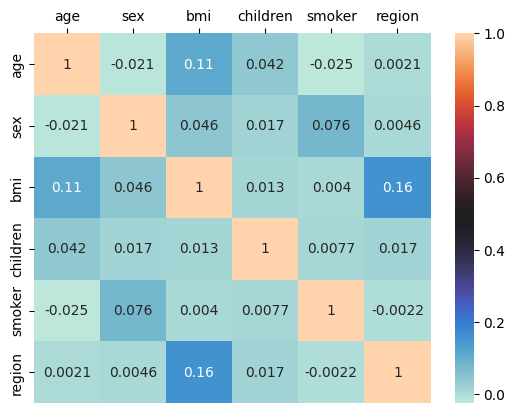

In [26]:
import seaborn as sns
ax = sns.heatmap(matriz_corr, annot=True, cmap="icefire")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

In [27]:
# Gerando eigenvalues e eigenvectors
corr = np.corrcoef(X, rowvar = 0)
eigenvalues, eigenvectors = np.linalg.eig(corr)

In [28]:
print (eigenvalues)

[1.20353877 0.79945339 1.08819843 1.01952977 0.96532425 0.92395539]


Valores próximos a zero podem representar um problema real para equações normais e outros métodos de otimização baseados na inversão matricial. Valores pequenos representam uma fonte elevada, mas não crítica, de multicolinearidade.

In [29]:
print (eigenvectors[:,1])

[ 4.15350476e-01  2.00352579e-01 -6.93018568e-01 -1.06317912e-01
 -6.01366979e-04  5.43842100e-01]


Todas as variáveis representam multicolinearidade.

## Importância dos atributos

In [30]:
# Criando um modelo
modelo = linear_model.LinearRegression(normalize = False, fit_intercept = True)

In [31]:
# Treinando o modelo com dados não padronizados
modelo.fit(X,y)

LinearRegression(normalize=False)

In [32]:
# Imprimindo os coeficientes e as variáveis
for coef, var in sorted(zip(map(abs, modelo.coef_), df_copy.columns[:-1]), reverse = True):
    print ("%6.3f %s" % (coef,var))

23819.322 smoker
479.565 children
353.485 region
332.645 bmi
257.272 age
131.146 sex


In [33]:
# Padronizando os dados
standardization = StandardScaler()
Stand_coef_linear_reg = make_pipeline(standardization, modelo)

In [34]:
# Treinando o modelo com dados padronizados (na mesma escala)
Stand_coef_linear_reg.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression(normalize=False))])

In [35]:
# Imprimindo os coeficientes e as variáveis
for coef, var in sorted(zip(map(abs, Stand_coef_linear_reg.steps[1][1].coef_), df_copy.columns[:-1]), reverse = True):
    print ("%6.3f %s" % (coef,var))

9612.124 smoker
3613.317 age
2027.837 bmi
577.896 children
390.415 region
65.569 sex


### Usando R squared 

In [36]:
modelo = linear_model.LinearRegression(normalize = False, fit_intercept = True)

In [37]:
def r2_est(X,y):
    return r2_score(y, modelo.fit(X,y).predict(X))

In [38]:
print ('Coeficiente R2: %0.3f' %  r2_est(X,y))

Coeficiente R2: 0.751


In [39]:
# Gera o impacto de cada atributo no R2
r2_impact = list()
for j in range(X.shape[1]):
    selection = [i for i in range(X.shape[1]) if i!=j]
    r2_impact.append(((r2_est(X,y) - r2_est(X.values[:,selection],y)), df_copy.columns[j]))
    
for imp, varname in sorted(r2_impact, reverse = True):
    print ('%6.3f %s' %  (imp, varname))

 0.626 smoker
 0.088 age
 0.027 bmi
 0.002 children
 0.001 region
 0.000 sex


## Segunda versão do modelo

Nesta versão, serão utilizadas variáveis com base na importância dos seus atributos.

In [40]:
df_copy.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [41]:
# Formato do dataframe
print("Dataframe tem {} observações com {} variáveis cada uma.".format(*df_copy.shape))

Dataframe tem 1338 observações com 7 variáveis cada uma.


In [42]:
# Coletando x e y
# Usaremos como variáveis explanatórias somente as 3 mais relevantes
X = df_copy[["smoker", "age", "bmi"]]
y = df_copy["expenses"].values

In [43]:
X.head()

,smoker,age,bmi
0,1,19,27.9
1,0,18,33.8
2,0,28,33.0
3,0,33,22.7
4,0,32,28.9


In [44]:
y

array([16884.92,  1725.55,  4449.46, ...,  1629.83,  2007.95, 29141.36])

In [45]:
# Divisão em dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [46]:
# Cria o modelo
modelo = LinearRegression(normalize = False, fit_intercept = True)

In [47]:
# Treina o modelo
modelo_v2 = modelo.fit(X_train, y_train)

In [48]:
# Calcula a métrica R2 do nosso modelo
r2_score(y_test, modelo_v2.fit(X_train, y_train).predict(X_test))

0.7776737555148192

In [49]:
# Produz a matriz com os novos dados de entrada para a previsão
smoker = 0
age = 31
bmi = 28.9

# Lista com os valores das variáveis
dados_novos = [smoker, age, bmi]

# Reshape
Xp = np.array(dados_novos).reshape(1, -1)

# Previsão
print("Valor do seguro:", modelo_v2.predict(Xp))

Valor do seguro: [5767.81106678]


## Terceira versão do modelo com todas as variáveis explanatórias

In [50]:
df_copy.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [51]:
# Coletando x e y
# Usaremos como variáveis explanatórias todas as variáveis
X3 = df_copy[["age", "sex", "bmi", "children", "smoker", "region"]]
y3 = df_copy["expenses"].values

In [52]:
X3.head(2)

,age,sex,bmi,children,smoker,region
0,19,0,27.9,0,1,3
1,18,1,33.8,1,0,2


In [53]:
y3

array([16884.92,  1725.55,  4449.46, ...,  1629.83,  2007.95, 29141.36])

In [54]:
# Divisão em dados de treino e de teste
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state = 42)

In [55]:
# Cria o modelo
modelo = LinearRegression(normalize = False, fit_intercept = True)

In [56]:
# Treina o modelo
modelo_v3 = modelo.fit(X3_train, y3_train)

In [57]:
# Calcula a métrica R2 do nosso modelo
r2_score(y3_test, modelo_v3.fit(X3_train, y3_train).predict(X3_test))

0.7833214205203848

In [58]:
df_copy.head(1)

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92


In [59]:
# Produz a matriz com os novos dados de entrada para a previsão
age = 25
sex = 0
bmi = 25.7
children = 0
smoker = 0
region = 2

# Lista com os valores das variáveis
dados_v3 = [age, sex, bmi, children, smoker, region]
# Reshape
Xp = np.array(dados_v3).reshape(1, -1)

# Previsão
print("Valor do seguro:", modelo_v3.predict(Xp))

Valor do seguro: [2565.47529213]


In [69]:
!jupyter nbconvert --to pdf "Análise de Custos Para Seguro Saúde".ipynb


[NbConvertApp] Converting notebook Análise de Custos Para Seguro Saúde.ipynb to pdf
[NbConvertApp] Support files will be in Análise de Custos Para Seguro Saúde_files\
[NbConvertApp] Making directory .\Análise de Custos Para Seguro Saúde_files
[NbConvertApp] Writing 77748 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 386722 bytes to Análise de Custos Para Seguro Saúde.pdf
